# Resale Flat Prices

## Summary
- Data source: [Resale flat prices based on registration date from Jan-2017 onwards](https://beta.data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view)
  - Time range: `Jan 2017 - Apr 2024`
  - The approximate floor area includes any recess area purchased, space adding item under HDB’s upgrading programmes, roof terrace, etc.

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
spark

Custom Spark Session (App ID: app-20240621082107-0017) - UI: http://f294e9875600:4041

## Load Source Data

In [3]:
source_df = spark.read.csv('/opt/data/datasets/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv', header=True, inferSchema=True)
source_df.show(10)

+-------------------+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+------------------+------------+
|              month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|   remaining_lease|resale_price|
+-------------------+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+------------------+------------+
|2017-01-01 00:00:00|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|61 years 04 months|    232000.0|
|2017-01-01 00:00:00|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|60 years 07 months|    250000.0|
|2017-01-01 00:00:00|ANG MO KIO|   3 ROOM|  602| ANG MO KIO AVE 5|    01 TO 03|          67.0|New Generation|               1980|62 years 05 months|    262000.0|
|2017-01-01 00:00:00|ANG MO 

In [4]:
source_df.write.format("delta").mode("overwrite").saveAsTable("resale_flat_prices")

In [5]:
spark.sql("show tables").show()

+---------+------------------+-----------+
|namespace|         tableName|isTemporary|
+---------+------------------+-----------+
|  default|resale_flat_prices|      false|
+---------+------------------+-----------+



In [6]:
resale_flat_prices_df = spark.sql("SELECT * FROM resale_flat_prices")
resale_flat_prices_df.show(5)

+-------------------+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+------------------+------------+
|              month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|   remaining_lease|resale_price|
+-------------------+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+------------------+------------+
|2017-01-01 00:00:00|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|61 years 04 months|    232000.0|
|2017-01-01 00:00:00|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|60 years 07 months|    250000.0|
|2017-01-01 00:00:00|ANG MO KIO|   3 ROOM|  602| ANG MO KIO AVE 5|    01 TO 03|          67.0|New Generation|               1980|62 years 05 months|    262000.0|
|2017-01-01 00:00:00|ANG MO 

In [7]:
spark.sql("DESCRIBE resale_flat_prices").show()

+-------------------+---------+-------+
|           col_name|data_type|comment|
+-------------------+---------+-------+
|              month|timestamp|   NULL|
|               town|   string|   NULL|
|          flat_type|   string|   NULL|
|              block|   string|   NULL|
|        street_name|   string|   NULL|
|       storey_range|   string|   NULL|
|     floor_area_sqm|   double|   NULL|
|         flat_model|   string|   NULL|
|lease_commence_date|      int|   NULL|
|    remaining_lease|   string|   NULL|
|       resale_price|   double|   NULL|
+-------------------+---------+-------+



## Data Exploration

In [8]:
spark.sql("""
    select 
        count(distinct town) as town_number,
        count(distinct flat_type) as flat_type_number,
        count(distinct flat_model) as flat_model_number
    from resale_flat_prices
""").show()

+-----------+----------------+-----------------+
|town_number|flat_type_number|flat_model_number|
+-----------+----------------+-----------------+
|         26|               7|               21|
+-----------+----------------+-----------------+



In [9]:
spark.sql("""
    select distinct flat_type
    from resale_flat_prices
""").show()

+----------------+
|       flat_type|
+----------------+
|          3 ROOM|
|          1 ROOM|
|          4 ROOM|
|          2 ROOM|
|       EXECUTIVE|
|          5 ROOM|
|MULTI-GENERATION|
+----------------+



### Flat Number Per Town

In [10]:
avg_flats_df = spark.sql("""
    select 
        town,
        count(*) as flat_number
    from resale_flat_prices
    group by town
    order by 2 desc
""")

avg_flats_pd = avg_flats_df.toPandas()

In [11]:
plt.figure(figsize=(15, 5))
sns.barplot(x='town', y='flat_number', hue='town', data=avg_flats_pd, palette='coolwarm')
plt.xlabel('Town')
plt.ylabel('Average Number of Flats Sold')
plt.title('Average Number of Flats Sold Per Town')
plt.xticks(rotation=45)
plt.show()

### Average Flat Price Per Town

#### 2024
- Until April

In [12]:
avg_price_df = spark.sql("""
    select 
        town,
        flat_type,
        avg(resale_price) as avg_price
    from resale_flat_prices    
    where 
        flat_type not in ('EXECUTIVE', 'MULTI-GENERATION') 
        and year(month) = '2024'
    group by town, flat_type
    order by avg_price desc 
""")

avg_price_pd = avg_price_df.toPandas()

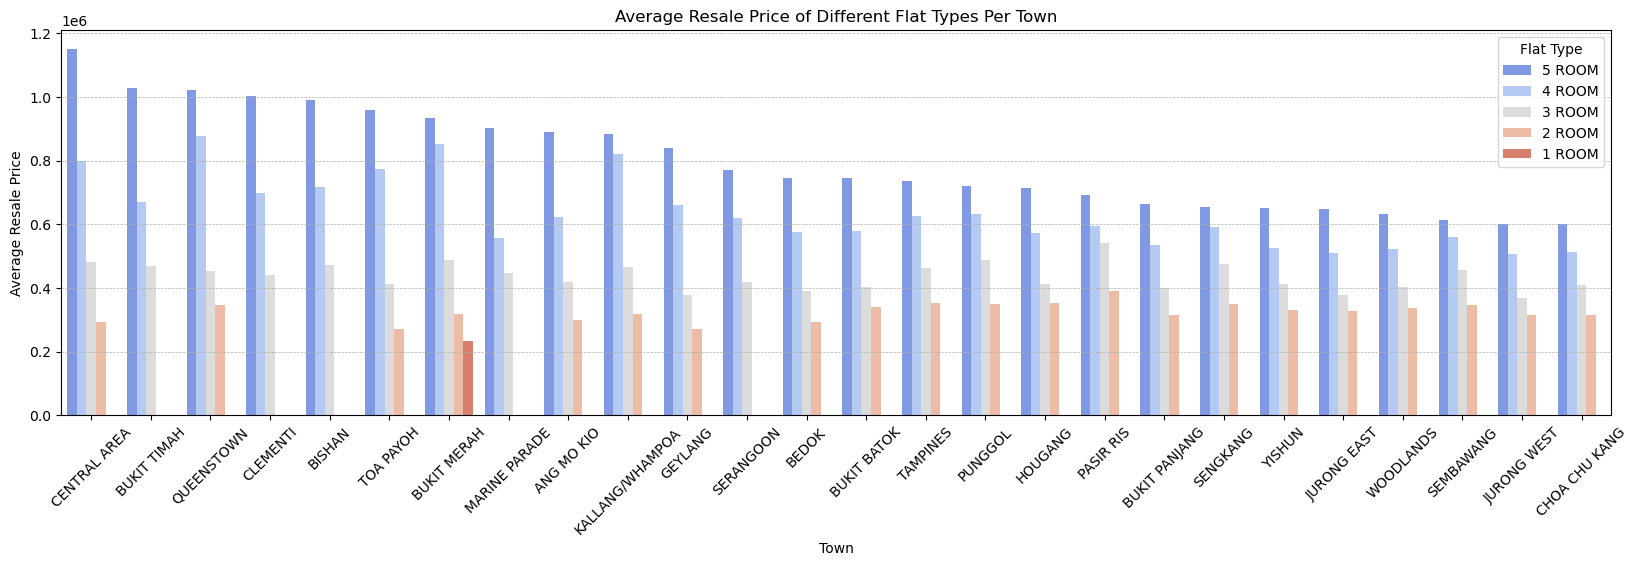

In [13]:
plt.figure(figsize=(20, 5))
ax = sns.barplot(x='town', y='avg_price', hue='flat_type', data=avg_price_pd, palette='coolwarm')
plt.xlabel('Town')
plt.ylabel('Average Resale Price')
plt.title('Average Resale Price of Different Flat Types Per Town')
plt.legend(title='Flat Type')
plt.xticks(rotation=45)

ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)  # Customize the grid lines

plt.show()

In [14]:
spark.stop()